# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

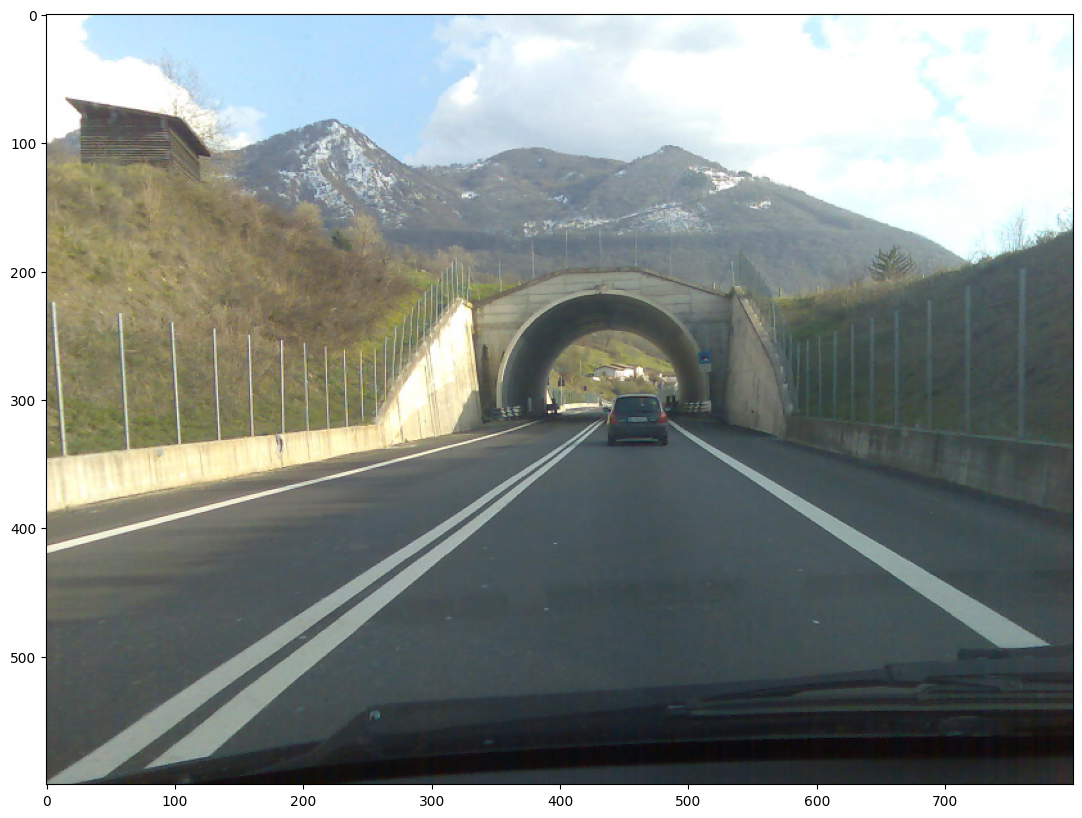

In [2]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

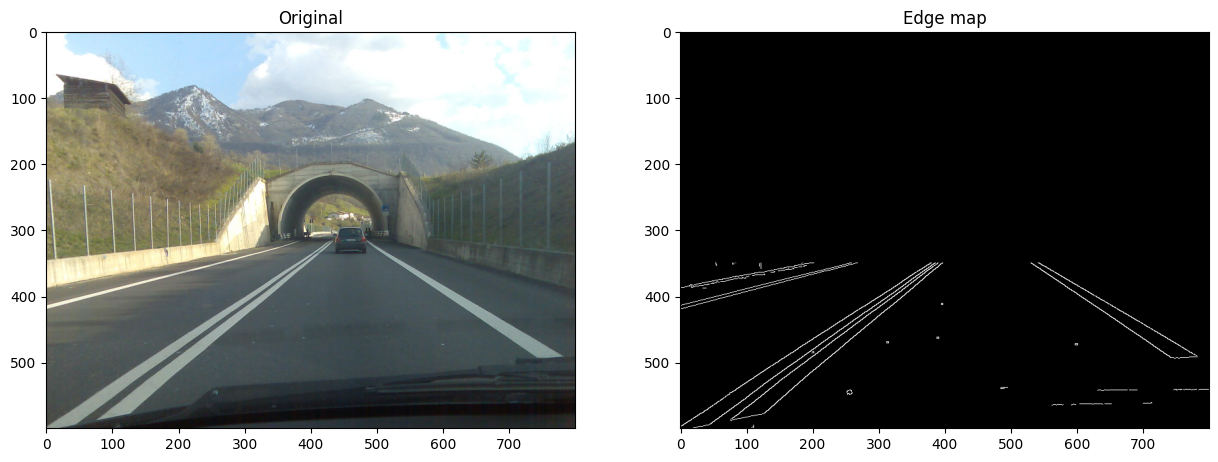

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [6]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)
# lines = cv2.HoughLines(edges, rho=1, theta=1*np.pi/180, threshold=190)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]
print(lines.shape, lines)

(10, 2) [[521.           0.87266463]
 [505.           0.94247776]
 [509.           0.9075712 ]
 [495.           0.9773844 ]
 [ -7.           2.1642082 ]
 [401.           1.3264502 ]
 [513.           0.94247776]
 [499.           1.012291  ]
 [ 31.           2.0943952 ]
 [511.           0.9773844 ]]


521.0 0.87266463
505.0 0.94247776
509.0 0.9075712
495.0 0.9773844
-7.0 2.1642082
401.0 1.3264502
513.0 0.94247776
499.0 1.012291
31.0 2.0943952
511.0 0.9773844


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

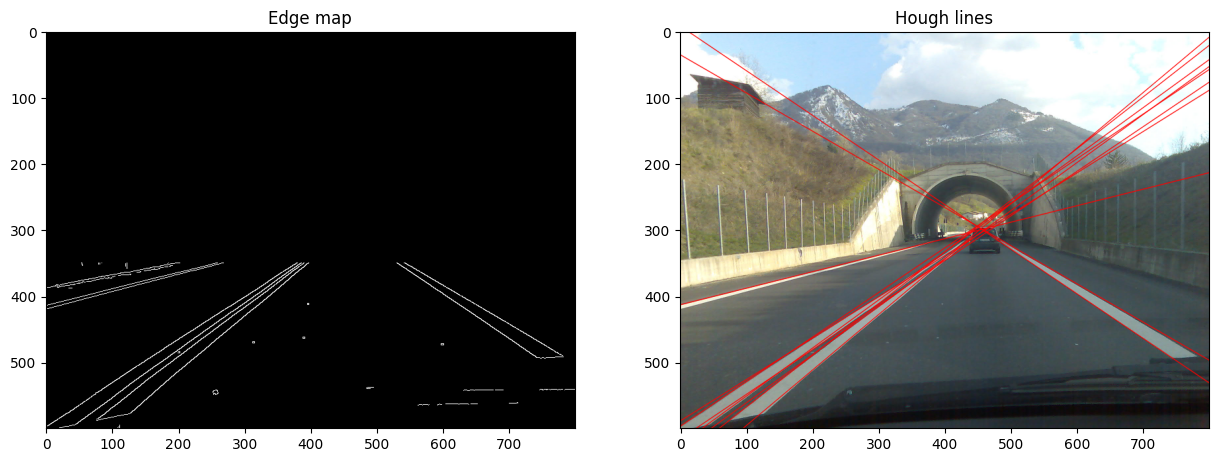

In [7]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    print(rho, theta)
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [8]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    delta_hor = 20*np.pi/180
    theta = line[1]
    # Keep line if theta is not horizontal
    if abs(theta - 90*np.pi/180) > delta_hor:
        filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

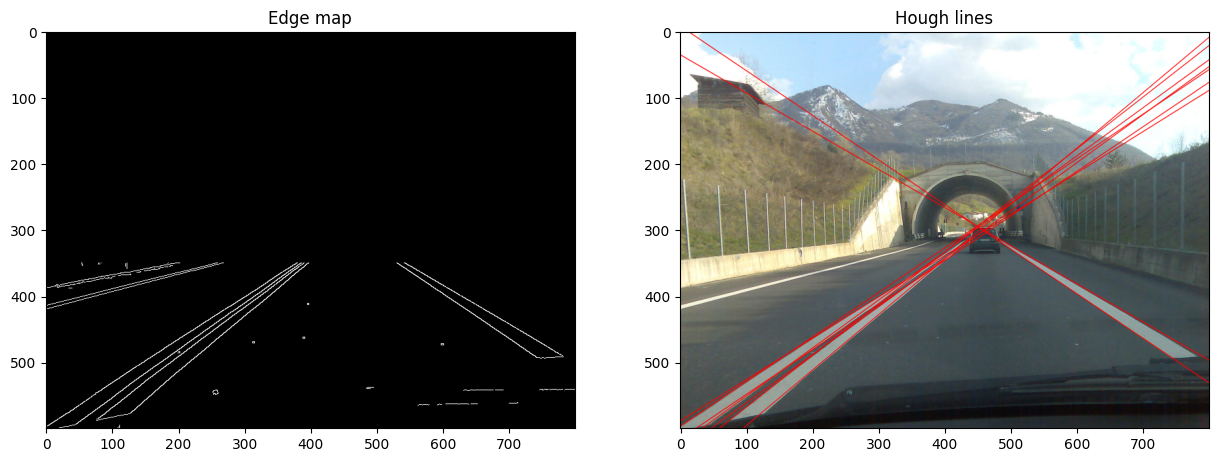

In [9]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)    
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [10]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[511.        ,   0.94247778],
       [ 31.        ,   2.09439516],
       [ -7.        ,   2.16420817],
       [497.        ,   0.99483767],
       [521.        ,   0.87266463],
       [505.        ,   0.94247776]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

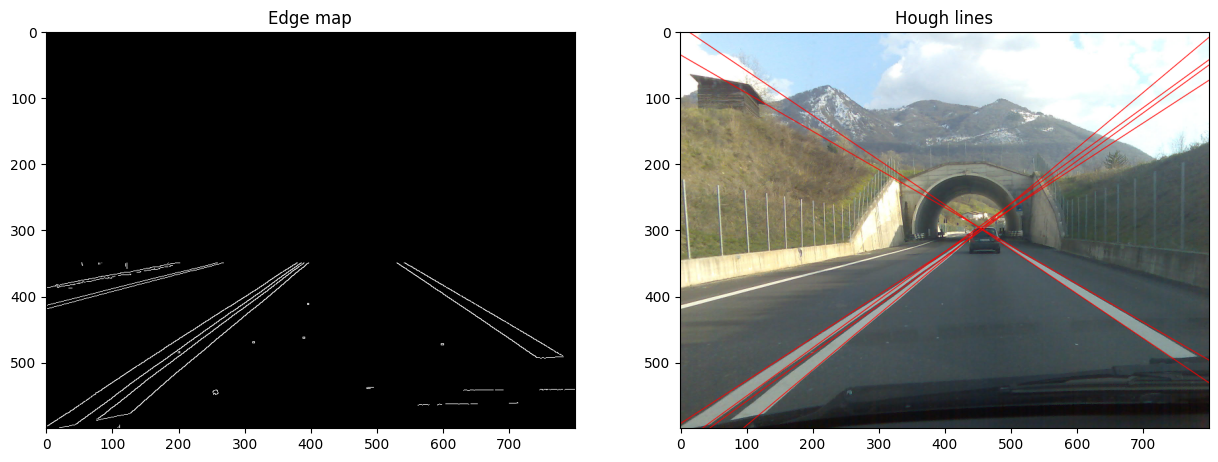

In [11]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    a = math.cos(theta)
    b = math.sin(theta)    
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result? Perhaps the received lines are not parallel to the stripes, perhaps due to some optical distortion of the lens. Or because rho is not 1, rho=2 and theta=2*np.pi/180.
* Do you think the Hough transform resolution is important for obtaining a good result? Why? It's important. If it's too small that means that we have less voting cells that leads to less number of lines. That's why some lines may be merged. If resolution is high. Than we can get many voting cells that will have may be lower values, and it will be difficult to select one primary line with good big voting value.
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why? Yes, it is important. Because we usually want to get some main lines that will limit the object in the image. Therefore, we are not interested in very short lines.

In [12]:
### JUST CODE FOR WORK WITH VIDEO ###

In [13]:
from ipywidgets import Video
from IPython.display import display
import cv2
import math

# Function to draw on frames
def draw_on_frame(frame):
    # Convert image to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
    # Hint: you can use Canny edge detector with th_low = 100, th_high = 150
    edges = cv2.Canny(gray, threshold1=100, threshold2=150)

    # We are only interseted in the road so we will remove everything above the horizon
    half_frame = 360
    edges[0:half_frame] = 0
    lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=190)
    # lines = cv2.HoughLines(edges, rho=1, theta=1*np.pi/180, threshold=190)
    # Let's get rid of the unnecessary dimension
    lines = lines[:, 0, :] 
    # Filter out all lines that are approximately horizontal (+/- 20 degrees). 
    filtered_lines = []
    for line in lines:
        # Extract theta for current line (remember Hough works with radians)
        delta_hor = 20*np.pi/180
        theta = line[1]
        # Keep line if theta is not horizontal
        if abs(theta - 90*np.pi/180) > delta_hor:
            filtered_lines.append(line)
    
    for line in filtered_lines:
        rho = line[0]
        theta = line[1]
        a = math.cos(theta)
        b = math.sin(theta)    
        
        x0 = a * rho
        y0 = b * rho
        
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(frame, pt1, pt2,(255, 0, 0)) #, color, thickness)
    return frame

# Open the original video
cap = cv2.VideoCapture('../data/output.mp4')

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec

# Create a VideoWriter object to write the video
out = cv2.VideoWriter('../data/output_modified.mp4', fourcc, fps, (width, height))

# Process the video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Draw on frame
    frame = draw_on_frame(frame)
    # Write the frame to the output video
    out.write(frame)


# Release resources
cap.release()
out.release()

# Display the modified video in Jupyter Lab
video_widget = Video.from_file('../data/output_modified.mp4')
display(video_widget)



Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x07y\xb0\x99...')